In [1]:
import os                                                                                                                                                                                       
import sys                                                                                                                                                                                      
import numpy as np                                                                                                                                                                              
import scipy.stats as ss                                                                                                                                                                        
import matplotlib.pyplot as plt                                                                                                                                                                 
from math import sqrt                                                                                                                                                                           
#from statsmodels.stats.proportion import proportion_confint                                                                                                                                     
from itertools import zip_longest                                                                                                                                                               
from scipy.optimize import bisect, root                                                                                                                                                         
                      
                         
# Functions in python and in R
# R qnorm = python .ppf()                                                                                                                                                                       
# R pnorm = python .cdf()                                                                                                                                                                       
# R dnorm = python .pmf() (I think)                                                                                                                                                             
                         

Let's define the number of our experiments, and the desired confidence level

In [2]:
n=20                                                                                                                                                                                            
conf_level=0.95                                                                                                                                                                                 
       

Now we define the function that computes coverage in the Gaussian approximation

In [3]:
                                                                                                                                                                                               
def cover_gauss(p):                                                                                                                                                                             
    if not (0 <= p and p <= 1):                                                                                                                                                                 
        sys.exit()                                                                                                                                                                              
    x = np.array(range(0, n))                                                                                                                                                                   
    fpx = ss.binom.pmf(x, n, p)                                                                                                                                                                 
    phat = x / n                                                                                                                                                                                
    crit_val = ss.norm.ppf((1 + conf_level) / 2)                                                                                                                                                
    low = [iphat - crit_val * sqrt(iphat * (1 - iphat) / n) for iphat in phat]                                                                                                                  
    hig = [iphat + crit_val * sqrt(iphat * (1 - iphat) / n) for iphat in phat]                                                                                                                  
    inies = [ int(ilow <= p and p <= ihig) for ilow, ihig in zip_longest(low, hig) ]                                                                                                            
    return sum(inies * fpx)                                                                                                                                                                     

# Let's just test it
print(cover_gauss(0.6))                                                                                                                                                                         
               

0.928019119328061


...and the one that computes coverage with the Clopper-Pearson intervals

In [4]:
def cover_clopper(p):                                                                                                                                                                                                                                   
    if not (0 <= p and p <= 1):                                                                                                                                                                                                                         
        sys.exit()                                                                                                                                                                                                                                      
    x = np.array(range(0, n))                                                                                                                                                                                                                           
    fpx = ss.binom.pmf(x, n, p)                                                                                                                                                                                                                                                                                                                                                                                                                           
    #print(proportion_confint(np.array(range(0,n)), n, alpha=conf_level, method="beta"))
    # Initially I did this, horribly not working
    #low = [ ss.beta.ppf(conf_level/2, ix, n-ix +1) for ix in x]                                                                                                                                                                                        
    #hig = [ ss.beta.ppf(1-conf_level/2, ix+1, n-ix) for ix in x]                                                                                                                                                                                       

    # This is the correct way, mimicking the R code below
    # although it still has issues at large p
    low = [ (ss.beta.ppf((1-conf_level)/2, ix, n-ix+1)   )  if ix != 0 else 0 for ix in x]                                                                                                                                                              
    hig = [ (ss.beta.ppf(1-(1-conf_level)/2, ix+1, n-ix ))  if ix != n else 1 for ix in x]                                                                                                                                                              
       
    # The original R code from stats.binom.test
    #    ## Determine p s.t. Prob(B(n,p) >= x) = alpha.                                                                                                                                                                                                 
    #    ## Use that for x > 0,                                                                                                                                                                                                                         
    #    ##   Prob(B(n,p) >= x) = pbeta(p, x, n - x + 1).                                                                                                                                                                                               
    #    p.L <- function(x, alpha) {                                                                                                                                                                                                                    
    #        if(x == 0)                      # No solution                                                                                                                                                                                              
    #            0                                                                                                                                                                                                                                      
    #        else                                                                                                                                                                                                                                       
    #            qbeta(alpha, x, n - x + 1)                                                                                                                                                                                                             
    #    }                                                                                                                                                                                                                                              
    #    ## Determine p s.t. Prob(B(n,p) <= x) = alpha.                                                                                                                                                                                                 
    #    ## Use that for x < n,                                                                                                                                                                                                                         
    #    ##   Prob(B(n,p) <= x) = 1 - pbeta(p, x + 1, n - x).                                                                                                                                                                                           
    #    p.U <- function(x, alpha) {                                                                                                                                                                                                                    
    #        if(x == n)                      # No solution                                                                                                                                                                                              
    #            1                                                                                                                                                                                                                                      
    #        else                                                                                                                                                                                                                                       
    #            qbeta(1 - alpha, x + 1, n - x)                                                                                                                                                                                                         
    #}                                                                                                                                                                                                                                                  
                                                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    inies = [ int(ilow <= p and p <= ihig) for ilow, ihig in zip_longest(low, hig) ]                                                                                                                                                                    
                                                                                                                                                                                                                                        
    return sum(inies * fpx)                                                                                                                                                                                                                             
                           
    # Let's test it
    print(cover_clopper(0.6))

OK, now produce the coverage plot

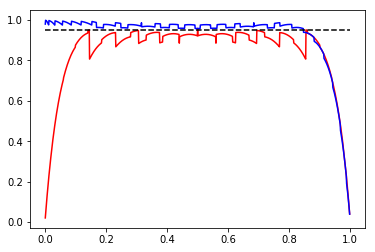

In [7]:
p= np.array(np.arange(0.001, 0.999, 0.001)) 
                                                                                                                                                                                                                                                       
fix, ax = plt.subplots(1,1)                                                                                                                                                                                                                                                                                                                                                                                                                                                  
plt.plot(p, [ cover_gauss(ip) for ip in p], color="red", linestyle="solid")                                                                                                                                                                             
plt.plot(p, [ cover_clopper(ip) for ip in p], color="blue", linestyle="solid")                                                                                                                                                                          
plt.plot(p, [ conf_level for ip in p ], color="black", linestyle="dashed")                                                                                                                                                                              
plt.show()  